In [1]:
from collections import Counter
import datetime as dt
import itertools

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

Thanks to Thomas Caswell for the following code on repository commits:

https://gist.github.com/tacaswell/e95cb2d57ca3783ffc40

Extract author + commit date from git from 2013-01-01 till now, for a local clone of https://github.com/JuliaLang/julia

```
echo 'time&name' > julia_commits.csv; 
git log --no-merges --since=2013-01-01 --pretty=format:'%at&%aN <%aE>' >> julia_commits.csv
```

The results are in [downloads/julia_commits.csv](../downloads/julia_commits.csv).

In [2]:
commits = pd.read_csv('downloads/julia_commits.csv', sep='&')
commits.head()

,time,name
0,1554837475,Jeff Bezanson <jeff.bezanson@gmail.com>
1,1554823269,Dream Scatter <18372368+chakravala@users.norep...
2,1554823066,Elliot Saba <staticfloat@gmail.com>
3,1554803115,Fredrik Ekre <ekrefredrik@gmail.com>
4,1554749412,Steven G. Johnson <stevenj@alum.mit.edu>


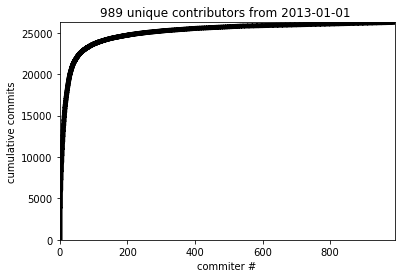

In [3]:
commiters = Counter(commits['name'])
commiter_number = list(range(len(commiters) + 1))
c_count = list(commiters.values())
cum_commits = np.r_[[0], np.cumsum(sorted(c_count, reverse=True))]

fig, ax = plt.subplots()
ax.step(commiter_number, cum_commits, where='post', color='k', lw=5)
ax.tick_params(axis='y', direction='out')
ax.tick_params(axis='x', direction='out')
ax.set_xlim([0, max(commiter_number)])
ax.set_ylim([0, np.sum(c_count)])
ax.set_ylabel('cumulative commits')
ax.set_xlabel('commiter #')
ax.set_title("{} unique contributors from 2013-01-01 ".
             format(max(commiter_number)-1));

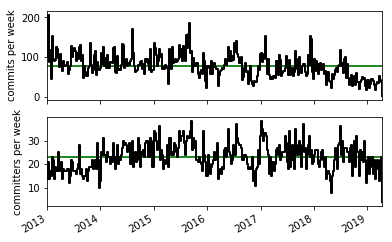

In [4]:
def stats_plotter(ax, left_edges, unq_by_week, col, ylabel):
    ln, = ax.step(left_edges,
                  unq_by_week[col], color='k', where='post', lw=2)

    hln = ax.axhline(unq_by_week[col].mean(), color='forestgreen', zorder=0, lw=2)
    ax.set_ylabel(ylabel)
    return ln, hln


def by_window_binner(ax1, ax2, commits, start, stop, step, window_name):
    edges = np.arange(start, stop + step, step)
    left_edges = [dt.datetime.fromtimestamp(t) for t in edges[:-1]]

    gb = commits.groupby(pd.cut(commits['time'], edges))
    unq_by_bin = gb.agg(lambda x: len(set(x)))
    
    stats_plotter(ax1, left_edges, unq_by_bin, 'time', 'commits per {}'.format(window_name))
    stats_plotter(ax2, left_edges, unq_by_bin, 'name', 'committers per {}'.format(window_name))

start = dt.datetime(2013, 1, 1).timestamp()
stop  = dt.datetime.now().timestamp()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
by_window_binner(ax1, ax2, commits, start, stop, 7*24*60*60, 'week')
ax1.set_xlim((dt.datetime(2013, 1, 1), dt.datetime(2019, 4, 10)))
fig.autofmt_xdate()

These are the [TIOBE language index ratings](https://www.tiobe.com/tiobe-index) for Julia, recovered from <www.archive.org>.

> The ratings are based on the number of skilled engineers world-wide, courses and third party vendors. Popular search engines such as Google, Bing, Yahoo!, Wikipedia, Amazon, YouTube and Baidu are used to calculate the ratings

Get the data file from [downloads/julia_tiobe.csv](../downloads/julia_tiobe.csv)

In [5]:
julia_tiobe = pd.read_csv('downloads/julia_tiobe.csv')
julia_tiobe.head()

,year_month,pct
0,2017-1,<0.207
1,2017-2,<0.236
2,2017-3,0.320
3,2017-4,<0.258
4,2017-5,<0.277


In [6]:
julia_tiobe['pct'] = julia_tiobe['pct'].apply(lambda x : x.strip())
julia_tiobe['below'] = julia_tiobe['pct'].apply(lambda x : x.startswith('<'))
julia_tiobe.head()

,year_month,pct,below
0,2017-1,<0.207,True
1,2017-2,<0.236,True
2,2017-3,0.320,False
3,2017-4,<0.258,True
4,2017-5,<0.277,True


In [7]:
def recode_pct(val):
    if val.startswith('<'):
        val = val[1:]
    return float(val)

In [8]:
julia_tiobe['pct_val'] = julia_tiobe['pct'].apply(recode_pct)
julia_tiobe['dt'] = pd.to_datetime(julia_tiobe['year_month'])
julia_tiobe.head()

,year_month,pct,below,pct_val,dt
0,2017-1,<0.207,True,0.207,2017-01-01
1,2017-2,<0.236,True,0.236,2017-02-01
2,2017-3,0.320,False,0.320,2017-03-01
3,2017-4,<0.258,True,0.258,2017-04-01
4,2017-5,<0.277,True,0.277,2017-05-01


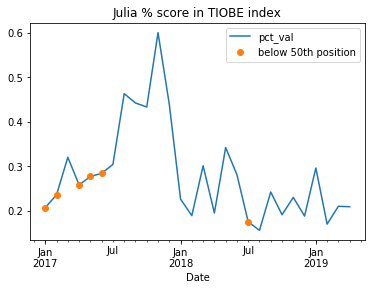

In [9]:
ax = julia_tiobe.plot('dt', 'pct_val')
belows = julia_tiobe[julia_tiobe['below']]
belows.plot('dt', 'pct_val', style='o', label='below 50th position', ax=ax)
plt.title('Julia % score in TIOBE index')
plt.xlabel('Date');

Finally, the percentage of Julia pull requests, in all pull requests on Github.  [These data](../downloads/julia_gh_prs.csv) scraped by hand from <https://madnight.github.io/githut>.

In [10]:
julia_prs = pd.read_csv('downloads/julia_gh_prs.csv')
julia_prs.head()

,Year,Quarter,Python,R,Julia
0,2018,4,17.739,0.167,0.093
1,2018,3,17.503,0.191,0.115
2,2018,2,16.256,0.220,0.084
3,2018,1,16.127,0.229,0.112
4,2017,4,15.823,0.163,0.207


In [11]:
julia_prs['Month'] = (julia_prs['Quarter'] - 1) * 3 + 2
datish = julia_prs.apply(
    lambda x: f"{x['Year']:0.0f}-{x['Month']:0.0f}", axis=1)
julia_prs['Date'] = pd.to_datetime(datish)
julia_prs.head()

,Year,Quarter,Python,R,Julia,Month,Date
0,2018,4,17.739,0.167,0.093,11,2018-11-01
1,2018,3,17.503,0.191,0.115,8,2018-08-01
2,2018,2,16.256,0.220,0.084,5,2018-05-01
3,2018,1,16.127,0.229,0.112,2,2018-02-01
4,2017,4,15.823,0.163,0.207,11,2017-11-01


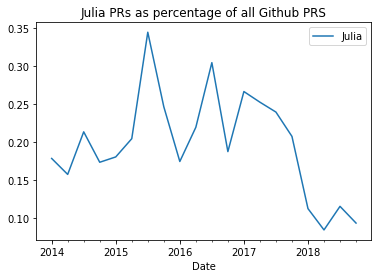

In [12]:
julia_prs.plot('Date', 'Julia')
plt.title("Julia PRs as percentage of all Github PRS");

[Redmonk index](https://redmonk.com/sogrady/category/programming-languages) positions.  Slightly guessed from figures in the text.

| Year | Quarter | Position |
|------|---------|----------|
| 2018 | 4       | 34       |
| 2018 | 2       | 36       |
| 2018 | 1       | 39       |
| 2017 | 4       | 40       |
| 2017 | 3       | 52       |